<a href="https://colab.research.google.com/github/verg1lio/XangoER/blob/rascunho_Leonardo/Identificardor_de_Parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Estimação de curva EMRAX268 - Escalas Invertidas
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Dados de RPM e valores característicos
rpm = np.array([0, 1000, 2000, 3000, 3500, 4000, 4500, 5000, 5500])

# Valores de potência (escala à esquerda)
potencia_continua = np.array([0, 20, 40, 60, 75, 85, 90, 95, 97])
potencia_pico = np.array([0, 50, 100, 150, 180, 200, 210, 215, 215])

# Valores de torque (escala à direita)
torque_continuo = np.array([200, 200, 200, 200, 190, 170, 150, 130, 110])
torque_pico = np.array([500, 500, 500, 500, 480, 450, 400, 370, 350])

# Interpolação suavizada
rpm_interp = np.linspace(0, 5500, 1000)
torque_continuo_interp = interp1d(rpm, torque_continuo, kind='cubic')(rpm_interp)
torque_pico_interp = interp1d(rpm, torque_pico, kind='cubic')(rpm_interp)
potencia_continua_interp = interp1d(rpm, potencia_continua, kind='cubic')(rpm_interp)
potencia_pico_interp = interp1d(rpm, potencia_pico, kind='cubic')(rpm_interp)

# Configuração do gráfico com escalas invertidas
fig, ax1 = plt.subplots(figsize=(10, 6))

# Curvas de Potência (eixo Y esquerdo)
ax1.set_xlabel('Motor speed (RPM)', fontsize=12)
ax1.set_ylabel('Power (kW)', color='tab:green', fontsize=12)
ax1.plot(rpm_interp, potencia_continua_interp, label='Continuous power', color='tab:green', linestyle='--', linewidth=2)
ax1.plot(rpm_interp, potencia_pico_interp, label='Peak power', color='tab:green', linewidth=2)
ax1.set_ylim(0, 220)
ax1.tick_params(axis='y', labelcolor='tab:green')

# Curvas de Torque (eixo Y direito)
ax2 = ax1.twinx()
ax2.set_ylabel('Torque (Nm)', color='tab:blue', fontsize=12)
ax2.plot(rpm_interp, torque_continuo_interp, label='Continuous torque', color='tab:blue', linestyle='--', linewidth=2)
ax2.plot(rpm_interp, torque_pico_interp, label='Peak torque', color='tab:blue', linewidth=2)
ax2.set_ylim(0, 550)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Formatação final
fig.suptitle('EMRAX 268MV LC - Torque and Power Curves', fontsize=14)
ax1.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98))
ax2.legend(loc="upper right", bbox_to_anchor=(0.98, 0.98))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

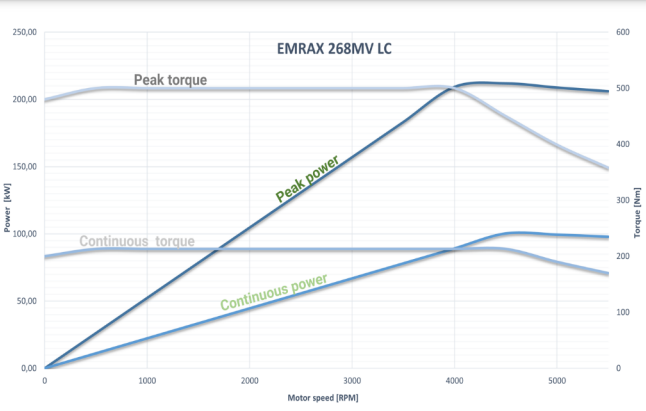

Parâmetros otimizados: R1 = 0.002000 Ω, L1 = 0.00001645 H, R2 = 0.000011Ω, L2 = 0.00000237H, Lm = 1.10917551


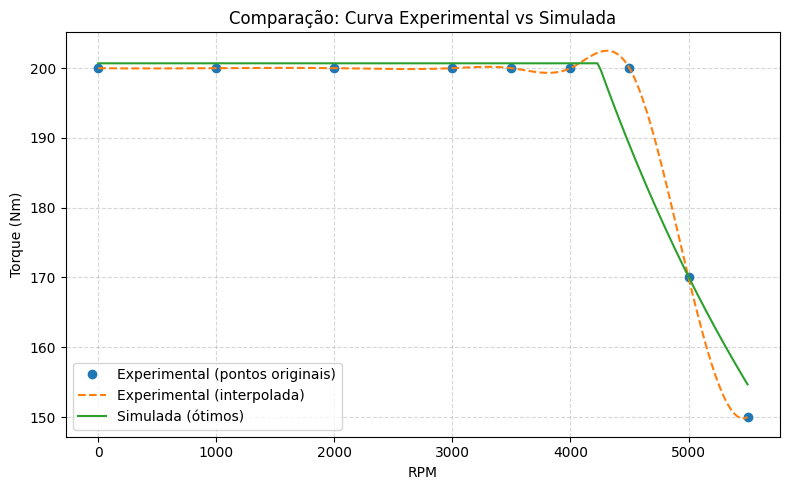

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import scipy.optimize as opt


def interpolar_curvas(rpm, valores, num_pontos=1000, kind='cubic'):
    """
    Interpola suavemente um conjunto de pontos.
    """
    rpm_interp = np.linspace(rpm.min(), rpm.max(), num_pontos)
    f = interp1d(rpm, valores, kind=kind)
    return rpm_interp, f(rpm_interp)


def plot_torque_power_curves(rpm, cont_power, peak_power, cont_torque, peak_torque):
    """
    Plota curvas de potência e torque com eixos Y duplos.
    """
    rpm_i, pc_i = interpolar_curvas(rpm, cont_power)
    _, pp_i = interpolar_curvas(rpm, peak_power)
    _, tc_i = interpolar_curvas(rpm, cont_torque)
    _, tp_i = interpolar_curvas(rpm, peak_torque)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('RPM')
    ax1.set_ylabel('Power (kW)', color='green')
    ax1.plot(rpm_i, pc_i, '--', label='Contínua', linewidth=2)
    ax1.plot(rpm_i, pp_i,     label='Pico',     linewidth=2)
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.set_ylim(0, max(peak_power)*1.1)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Torque (Nm)', color='blue')
    ax2.plot(rpm_i, tc_i, '--', label='Contínuo', linewidth=2)
    ax2.plot(rpm_i, tp_i,     label='Pico',     linewidth=2)
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, max(peak_torque)*1.1)

    fig.suptitle('Curvas de Torque e Potência')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


class MotorDeGaiola:
    """
    Modelo de motor de indução (gaiola de esquilo).
    """
    def __init__(self, frequencia, polos, R1, L1, R2, L2, Lm, K, Fn):
        self.f = frequencia
        self.polos = polos
        self.R1, self.L1 = R1, L1
        self.R2, self.L2 = R2, L2
        self.X1 = L1 * 2 * np.pi * self.f
        self.X2 = L2 * 2 * np.pi * self.f
        self.Lm = Lm
        self.Xm = Lm * 2 * np.pi * self.f
        self.K = K
        self._update_sync_speed()
        self.Fn=Fn

    def _update_sync_speed(self):
        self.omega_sync = 2 * np.pi * self.f / (self.polos / 2)

    def set_frequencia(self, f):
        self.f = f
        self._update_sync_speed()

    def _impedancias(self, s):
        j = 1j
        Z1 = self.R1 + j*self.X1
        Z2 = self.R2/s + j*self.X2
        Zm = j*self.Xm
        Z2p = (Z2*Zm)/(Z2+Zm)
        return Z1, Z1 + Z2p

    def torque(self, Vfase, s):
        Z1, Ztot = self._impedancias(s)
        I1 = Vfase / Ztot
        E2 = Vfase - I1*Z1
        I2 = np.abs(E2 / (self.R2/s + 1j*self.X2))
        Pr = 3 * I2**2 * (self.R2/s)

        if self.f <= self.Fn:
            w_s_nominal = 2 * np.pi * self.Fn / (self.polos/ 2)
            return self.K * Pr / w_s_nominal
        else:
            return self.K * Pr / self.omega_sync



    def gerar_malha(self, Vfase, slips, f_min, f_max, passo):
        freqs = np.arange(f_min, f_max+passo, passo)
        slips = np.array(slips)
        T = np.zeros((len(freqs), len(slips)))
        for i, f in enumerate(freqs):
            self.set_frequencia(f)
            T[i,:] = [self.torque(Vfase, s) for s in slips]
        return freqs, slips, T

    def plot_superficie(self, Vfase, slips, polos, f_min=1, f_max=375, passo=1.87):
        freqs, slips, T = self.gerar_malha(Vfase, slips, f_min, f_max, passo)
        rpm = 120 * freqs / polos

        # Curva nominal e máxima
        s_nom = 0.03
        idx_nom = np.argmin(np.abs(slips - s_nom))
        T_nom = T[:, idx_nom]
        T_max = T.max(axis=1)
        s_max = slips[T.argmax(axis=1)]
        P_nom = T_nom * (2*np.pi*freqs/(polos/2))
        P_max = T_max * (2*np.pi*freqs/(polos/2))

        # 3D
        fig = go.Figure()
        fig.add_trace(go.Surface(x=slips, y=rpm, z=T, opacity=0.8, colorbar=dict(title='Torque')))
        fig.add_trace(go.Scatter3d(x=[s_nom]*len(rpm), y=rpm, z=T_nom,
                                  mode='lines', line=dict(color='red', width=4),
                                  name='Torque Nominal'))
        fig.add_trace(go.Scatter3d(x=s_max, y=rpm, z=T_max,
                                  mode='lines', line=dict(color='blue', width=4),
                                  name='Torque Máximo'))

        # Invertendo a direção do eixo Y (RPM)
        fig.update_layout(scene=dict(
            xaxis_title='Slip',
            yaxis=dict(title='RPM', autorange='reversed'),
            zaxis_title='Torque'
        ),
        title='Superfície Torque vs Slip vs RPM',
        width=800, height=600)

        #fig.show()

        # 2D
        fig2 = go.Figure()
        fig2.add_trace(go.Scatter(x=rpm, y=P_nom,   mode='lines', name='P Nominal'))
        fig2.add_trace(go.Scatter(x=rpm, y=P_max,   mode='lines', name='P Máxima', line=dict(dash='dash')))
        fig2.add_trace(go.Scatter(x=rpm, y=T_nom,   mode='lines', name='T Nominal',   yaxis='y2'))
        fig2.add_trace(go.Scatter(x=rpm, y=T_max,   mode='lines', name='T Máximo',    yaxis='y2', line=dict(dash='dash')))
        fig2.update_layout(xaxis_title='RPM',
                           yaxis=dict(title='Potência (W)'),
                           yaxis2=dict(title='Torque (Nm)', overlaying='y', side='right'),
                           title='Potência vs Torque',
                           width=800, height=500)
        #fig2.show()
        return T_nom, T_max


def otimizar_parametros(motor, Vfase, slips, torque_exp, bounds, iniciais):
    """
    Ajusta R2, X2, Xm para minimizar erro quadrático.
    """
    def erro(params):
        motor.R2, motor.X2, motor.Xm = params
        sim = motor.plot_superficie(Vfase, slips, polos=10, f_min=1, f_max=485, passo=2.44)[0]
        return np.sum((sim - torque_exp)**2)
    result = opt.minimize(erro, iniciais, bounds=bounds)
    return result


if __name__ == '__main__':
    # Dados experimentais
    rpm = np.array([0,1000,2000,3000,3500,4000,4500,5000,5500])
    t_cont = np.array([200,200,200,200,200,200,200,170,150])

    # Malha de slips
    slips = np.linspace(0.001, 1, 200)
    # Curva experimental interpolada
    _, torque_exp = interpolar_curvas(rpm, t_cont, num_pontos=len(slips))

    # Configuração do motor e otimização
    motor = MotorDeGaiola(375, 10, 0.002, 0.00001645, 1.3, 2, 28, 0.94,375)
    bounds = [(0.000001,10)]*2 + [(0.00001,30)]
    iniciais = [0.00001,0.00001,0.00001]
    res = otimizar_parametros(motor, 380, slips, torque_exp, bounds, iniciais)
    print("Parâmetros otimizados: R1 = {:.6f} Ω, L1 = {:.8f} H, R2 = {:.6f}Ω, L2 = {:.8f}H, Lm = {:.8f}".format(0.002, 0.00001645, res.x[0],res.x[1],res.x[2]))

    # Gera curva simulada com parâmetros ótimos
    motor.R2, motor.X2, motor.Xm = res.x
    torque_sim = motor.plot_superficie(380, slips, polos=10, f_min=1, f_max=485, passo=2.44)[0]

    # Plot de comparação
    plt.figure(figsize=(8,5))
    plt.plot(rpm, t_cont, 'o', label='Experimental (pontos originais)')
    plt.plot(_, torque_exp, '--', label='Experimental (interpolada)')
    plt.plot(_, torque_sim,  '-', label='Simulada (ótimos)')
    plt.xlabel('RPM')
    plt.ylabel('Torque (Nm)')
    plt.title('Comparação: Curva Experimental vs Simulada')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


Parâmetros otimizados: R1 = 0.001667 Ω, L1 = 0.00166720 H, R2 = 0.001668Ω, L2 = 0.00166515H, Lm = 0.00028777


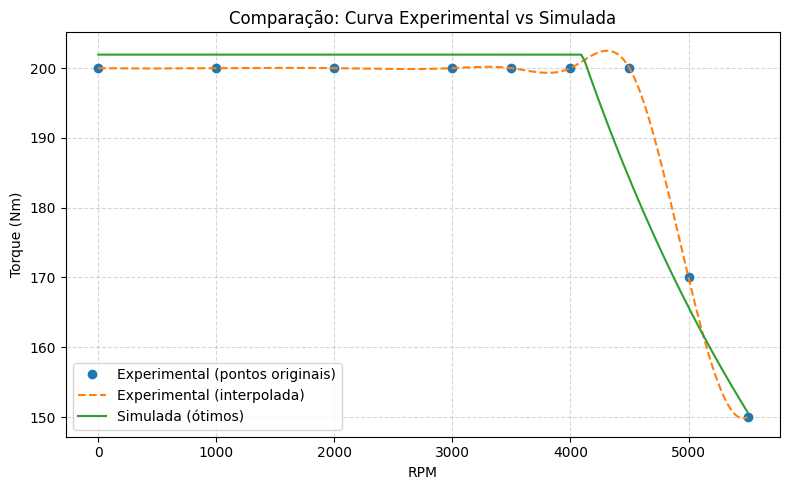

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import scipy.optimize as opt


def interpolar_curvas(rpm, valores, num_pontos=1000, kind='cubic'):
    """
    Interpola suavemente um conjunto de pontos.
    """
    rpm_interp = np.linspace(rpm.min(), rpm.max(), num_pontos)
    f = interp1d(rpm, valores, kind=kind)
    return rpm_interp, f(rpm_interp)


def plot_torque_power_curves(rpm, cont_power, peak_power, cont_torque, peak_torque):
    """
    Plota curvas de potência e torque com eixos Y duplos.
    """
    rpm_i, pc_i = interpolar_curvas(rpm, cont_power)
    _, pp_i = interpolar_curvas(rpm, peak_power)
    _, tc_i = interpolar_curvas(rpm, cont_torque)
    _, tp_i = interpolar_curvas(rpm, peak_torque)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('RPM')
    ax1.set_ylabel('Power (kW)', color='green')
    ax1.plot(rpm_i, pc_i, '--', label='Contínua', linewidth=2)
    ax1.plot(rpm_i, pp_i,     label='Pico',     linewidth=2)
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.set_ylim(0, max(peak_power)*1.1)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Torque (Nm)', color='blue')
    ax2.plot(rpm_i, tc_i, '--', label='Contínuo', linewidth=2)
    ax2.plot(rpm_i, tp_i,     label='Pico',     linewidth=2)
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, max(peak_torque)*1.1)

    fig.suptitle('Curvas de Torque e Potência')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


class MotorDeGaiola:
    """
    Modelo de motor de indução (gaiola de esquilo).
    """
    def __init__(self, frequencia, polos, R1, L1, R2, L2, Lm, K, Fn):
        self.f = frequencia
        self.polos = polos
        self.R1, self.L1 = R1, L1
        self.R2, self.L2 = R2, L2
        self.X1 = L1 * 2 * np.pi * self.f
        self.X2 = L2 * 2 * np.pi * self.f
        self.Lm = Lm
        self.Xm = Lm * 2 * np.pi * self.f
        self.K = K
        self._update_sync_speed()
        self.Fn=Fn

    def _update_sync_speed(self):
        self.omega_sync = 2 * np.pi * self.f / (self.polos / 2)

    def set_frequencia(self, f):
        self.f = f
        self._update_sync_speed()

    def _impedancias(self, s):
        j = 1j
        Z1 = self.R1 + j*self.X1
        Z2 = self.R2/s + j*self.X2
        Zm = j*self.Xm
        Z2p = (Z2*Zm)/(Z2+Zm)
        return Z1, Z1 + Z2p

    def torque(self, Vfase, s):
        Z1, Ztot = self._impedancias(s)
        I1 = Vfase / Ztot
        E2 = Vfase - I1*Z1
        I2 = np.abs(E2 / (self.R2/s + 1j*self.X2))
        Pr = 3 * I2**2 * (self.R2/s)

        if self.f <= self.Fn:
            w_s_nominal = 2 * np.pi * self.Fn / (self.polos/ 2)
            return self.K * Pr / w_s_nominal
        else:
            return self.K * Pr / self.omega_sync



    def gerar_malha(self, Vfase, slips, f_min, f_max, passo):
        freqs = np.arange(f_min, f_max+passo, passo)
        slips = np.array(slips)
        T = np.zeros((len(freqs), len(slips)))
        for i, f in enumerate(freqs):
            self.set_frequencia(f)
            T[i,:] = [self.torque(Vfase, s) for s in slips]
        return freqs, slips, T

    def plot_superficie(self, Vfase, slips, polos, f_min=1, f_max=375, passo=1.87):
        freqs, slips, T = self.gerar_malha(Vfase, slips, f_min, f_max, passo)
        rpm = 120 * freqs / polos

        # Curva nominal e máxima
        s_nom = 0.03
        idx_nom = np.argmin(np.abs(slips - s_nom))
        T_nom = T[:, idx_nom]
        T_max = T.max(axis=1)
        s_max = slips[T.argmax(axis=1)]
        P_nom = T_nom * (2*np.pi*freqs/(polos/2))
        P_max = T_max * (2*np.pi*freqs/(polos/2))

        # 3D
        fig = go.Figure()
        fig.add_trace(go.Surface(x=slips, y=rpm, z=T, opacity=0.8, colorbar=dict(title='Torque')))
        fig.add_trace(go.Scatter3d(x=[s_nom]*len(rpm), y=rpm, z=T_nom,
                                  mode='lines', line=dict(color='red', width=4),
                                  name='Torque Nominal'))
        fig.add_trace(go.Scatter3d(x=s_max, y=rpm, z=T_max,
                                  mode='lines', line=dict(color='blue', width=4),
                                  name='Torque Máximo'))

        # Invertendo a direção do eixo Y (RPM)
        fig.update_layout(scene=dict(
            xaxis_title='Slip',
            yaxis=dict(title='RPM', autorange='reversed'),
            zaxis_title='Torque'
        ),
        title='Superfície Torque vs Slip vs RPM',
        width=800, height=600)

        #fig.show()

        # 2D
        fig2 = go.Figure()
        fig2.add_trace(go.Scatter(x=rpm, y=P_nom,   mode='lines', name='P Nominal'))
        fig2.add_trace(go.Scatter(x=rpm, y=P_max,   mode='lines', name='P Máxima', line=dict(dash='dash')))
        fig2.add_trace(go.Scatter(x=rpm, y=T_nom,   mode='lines', name='T Nominal',   yaxis='y2'))
        fig2.add_trace(go.Scatter(x=rpm, y=T_max,   mode='lines', name='T Máximo',    yaxis='y2', line=dict(dash='dash')))
        fig2.update_layout(xaxis_title='RPM',
                           yaxis=dict(title='Potência (W)'),
                           yaxis2=dict(title='Torque (Nm)', overlaying='y', side='right'),
                           title='Potência vs Torque',
                           width=800, height=500)
        #fig2.show()
        return T_nom, T_max


def otimizar_parametros(motor, Vfase, slips, torque_exp, bounds, iniciais):
    """
    Ajusta R2, X2, Xm para minimizar erro quadrático.
    """
    def erro(params):
        motor.R1, motor.X1, motor.R2, motor.X2, motor.Xm = params
        sim = motor.plot_superficie(Vfase, slips, polos=10, f_min=1, f_max=500, passo=2.52)[0]
        return np.sum((sim - torque_exp)**2)
    result = opt.minimize(erro, iniciais, bounds=bounds)
    return result


if __name__ == '__main__':
    # Dados experimentais
    rpm = np.array([0,1000,2000,3000,3500,4000,4500,5000,5500])
    t_cont = np.array([200,200,200,200,200,200,200,170,150])

    # Malha de slips
    slips = np.linspace(0.001, 1, 200)
    # Curva experimental interpolada
    _, torque_exp = interpolar_curvas(rpm, t_cont, num_pontos=len(slips))

    # Configuração do motor e otimização
    motor = MotorDeGaiola(375, 10, 0.002, 0.00001645, 1.3, 2, 28, 0.94,375)
    bounds = [(0.000001,10)]*4 + [(0.00001,30)]
    iniciais = [0.00001,0.00001,0.00001,0.00001,0.00001]
    res = otimizar_parametros(motor, 380, slips, torque_exp, bounds, iniciais)
    print("Parâmetros otimizados: R1 = {:.6f} Ω, L1 = {:.8f} H, R2 = {:.6f}Ω, L2 = {:.8f}H, Lm = {:.8f}".format(res.x[0],res.x[1],res.x[2], res.x[3], res.x[4]))

    # Gera curva simulada com parâmetros ótimos
    motor.R1, motor.X1, motor.R2, motor.X2, motor.Xm = res.x
    torque_sim = motor.plot_superficie(380, slips, polos=10, f_min=1, f_max=500, passo=2.52)[0]

    # Plot de comparação
    plt.figure(figsize=(8,5))
    plt.plot(rpm, t_cont, 'o', label='Experimental (pontos originais)')
    plt.plot(_, torque_exp, '--', label='Experimental (interpolada)')
    plt.plot(_, torque_sim,  '-', label='Simulada (ótimos)')
    plt.xlabel('RPM')
    plt.ylabel('Torque (Nm)')
    plt.title('Comparação: Curva Experimental vs Simulada')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
